In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
from keras.preprocessing import image

2022-11-24 09:24:32.055190: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [37]:
SHAPE = 80
EPOCHS = 15 
NUM_CLASSES = 7

In [52]:
# Configure the training image generator
TRAINING_DIR = "./data/train/"
training_datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

# Configure the validation image generator
VALIDATION_DIR = "./data/test/"
validation_datagen = ImageDataGenerator(rescale = 1./255)

# Set the image size and batch size for training and validation
# generators 
train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(SHAPE,SHAPE),
    class_mode='categorical',
    batch_size=64
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(SHAPE,SHAPE),
    class_mode='categorical',
    batch_size=64
)

Found 7600 images belonging to 7 classes.
Found 1860 images belonging to 7 classes.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_generator = train_generator.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_generator = validation_generator.cache().prefetch(buffer_size=AUTOTUNE)

# Image informations

In [4]:
class_names = list(validation_generator.class_indices.keys())

print(class_names)

['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']


# Model creation

In [55]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image SHAPExSHAPE with
    # 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(SHAPE, SHAPE, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128 , (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    # tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    # tf.keras.layers.MaxPooling2D(2,2),
    # The sixth convolution
    # tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_41 (Conv2D)          (None, 78, 78, 64)        1792      
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 39, 39, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 37, 37, 64)        36928     
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 18, 18, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 8, 8, 128)      

# Training

In [58]:
model.compile(loss = 'categorical_crossentropy', optimizer="nadam", metrics=['accuracy'])

history = model.fit(train_generator, epochs=EPOCHS, steps_per_epoch=50, validation_data = validation_generator, verbose = 1, validation_steps=3)

model.save("trained_models/emotion.h5")

Epoch 1/30
50/50 [==============================] - 18s 320ms/step - loss: 1.6844 - accuracy: 0.3433 - val_loss: 1.5760 - val_accuracy: 0.4323
Epoch 2/30
50/50 [==============================] - 16s 316ms/step - loss: 1.6396 - accuracy: 0.3543 - val_loss: 1.5928 - val_accuracy: 0.4479
Epoch 3/30
50/50 [==============================] - 16s 315ms/step - loss: 1.6027 - accuracy: 0.3879 - val_loss: 1.4235 - val_accuracy: 0.4323
Epoch 4/30
50/50 [==============================] - 16s 315ms/step - loss: 1.5452 - accuracy: 0.4041 - val_loss: 1.2992 - val_accuracy: 0.5104
Epoch 5/30
50/50 [==============================] - 16s 311ms/step - loss: 1.5051 - accuracy: 0.4359 - val_loss: 1.3475 - val_accuracy: 0.4740
Epoch 6/30
50/50 [==============================] - 16s 311ms/step - loss: 1.4807 - accuracy: 0.4347 - val_loss: 1.2145 - val_accuracy: 0.5365
Epoch 7/30
50/50 [==============================] - 16s 317ms/step - loss: 1.4401 - accuracy: 0.4547 - val_loss: 1.2054 - val_accuracy: 0.5260

# History

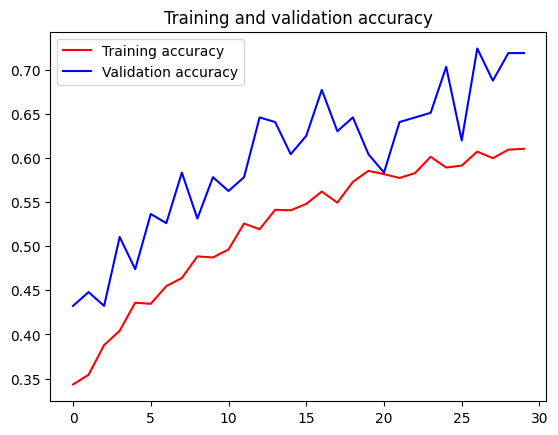

<Figure size 640x480 with 0 Axes>

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

# Validation

In [143]:
# 'anger' - 0, 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise'
model = tf.keras.models.load_model("trained_models/emotion.h5")

uploaded = ["./data/uploaded/happy.jpg", "./data/uploaded/sad.jpg"]
labels = ["happiness", "surprise"]

for i in range(len(labels)):
    labels[i] = class_names.index(labels[i])
print(labels)

images_predict = []
images = []

for img in uploaded:
    new_image = tf.keras.utils.load_img(img, target_size=(SHAPE, SHAPE))
    new_image_batch = tf.expand_dims(tf.keras.utils.img_to_array(new_image), 0)
    images_predict.append(new_image_batch)
    images.append(new_image)


[3, 6]


In [144]:
predictions_self = model.predict(images_predict[0])
print(predictions_self[0])

score = tf.nn.softmax(predictions_self[0])


print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 84ms/step
[0. 0. 0. 1. 0. 0. 0.]
This image most likely belongs to happiness with a 31.18 percent confidence.


In [131]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

predictions = probability_model.predict(images_predict[0])

print(predictions[0])
print(np.argmax(predictions[0]))

1/1 [==============================] - 0s 92ms/step
[0.1147015  0.1147015  0.1147015  0.31179097 0.1147015  0.1147015
 0.1147015 ]
3


In [128]:
def plot_image(predictions_array, true_label, img):
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label],
                                color=color)
                                )

def plot_value_array(predictions_array, true_label):
  plt.grid(False)
  plt.xticks(range(7))
  plt.yticks([])
  thisplot = plt.bar(range(7), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

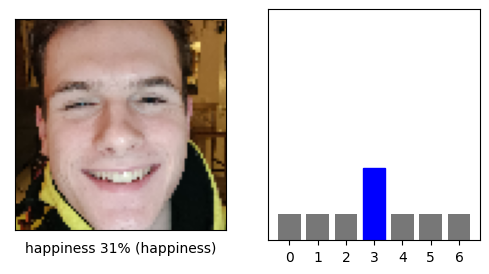

In [129]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(predictions[i], labels[i], images[i])
plt.subplot(1,2,2)
plot_value_array(predictions[i],  labels[i])
plt.show()

1/1 [==============================] - 0s 22ms/step


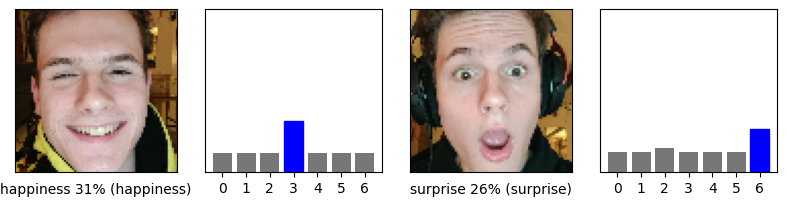

In [145]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = len(images)
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  predictions = probability_model.predict(images_predict[i])
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(predictions[0], labels[i], images[i])
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(predictions[0], labels[i])
plt.tight_layout()
plt.show()